<a href="https://colab.research.google.com/github/componavt/differential_equations/blob/main/src/hill_equation/deepxde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Compiling model...
Building feed-forward neural network...
'build' took 0.086774 s

'compile' took 0.453498 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.21e-01, 9.80e-01]    [1.18e-01, 9.80e-01]    []  
1000      [4.35e-04, 6.37e-04]    [4.28e-04, 6.37e-04]    []  
2000      [3.72e-04, 5.82e-04]    [3.54e-04, 5.82e-04]    []  
3000      [3.66e-04, 5.77e-04]    [3.45e-04, 5.77e-04]    []  
4000      [3.54e-04, 5.84e-04]    [3.29e-04, 5.84e-04]    []  
5000      [3.63e-04, 6.01e-04]    [3.47e-04, 6.01e-04]    []  

Best model at step 4000:
  train loss: 9.38e-04
  test loss: 9.13e-04
  test metric: []

'train' took 7.680076 s



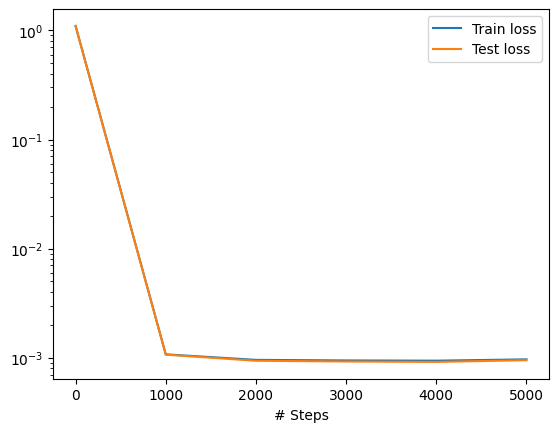

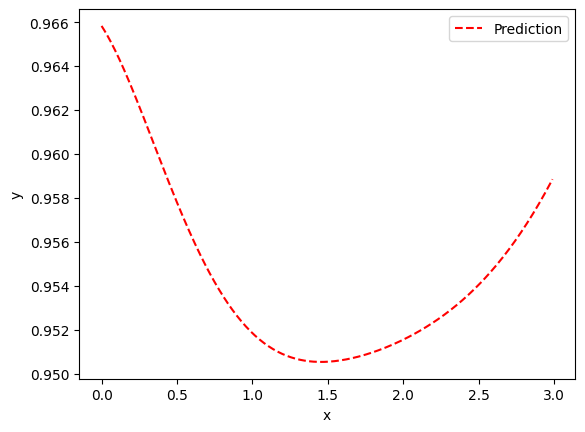

In [2]:
!pip install deepxde
import deepxde as dde
import numpy as np
import tensorflow as tf

# Параметры
alpha = 0.01  # Близко к нулю, но не ноль (сингулярность)
b = 1.0       # Пример значения b > 0

# Определение уравнения
def hill_equation(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=0)  # dy/dt
    x_alpha = tf.pow(y, 1/alpha)              # x^(1/alpha)
    b_alpha = tf.pow(b, 1/alpha)              # b^(1/alpha)
    return dy_t - x_alpha / (b_alpha + x_alpha)

# Геометрия (временной интервал)
geom = dde.geometry.TimeDomain(0, 3)

# Начальное условие x(0) ≈ b
x0 = b * 0.99  # Чуть меньше b
ic = dde.icbc.IC(geom, lambda x: x0, lambda _, on_initial: on_initial)

# Данные для обучения
data = dde.data.PDE(
    geom,
    hill_equation,
    ic,
    num_domain=100,
    num_boundary=2,
    num_test=300
)

# Архитектура нейросети
model = dde.Model(data, dde.nn.FNN([1] + [32] * 4 + [1], "tanh", "Glorot normal"))

# Компиляция и обучение
model.compile("adam", lr=0.001)
model.train(iterations=5000, display_every=1000)

# Визуализация
dde.saveplot(model.losshistory, model.train_state, issave=False, isplot=True)